###Let's start by installing the required libraries.
After this we have to restart runtime. This phase actually took a lot of time because of a lot of conflicts, this is why it's quite messy.

In [ ]:
# 1. Upgrade pip
!pip install --upgrade pip --quiet
print("pip upgraded.")

!pip install numpy>=2.0.0 --force-reinstall --no-cache-dir --quiet
print("Attempted to force install numpy >= 2.0.0.")

# 3. Install Pandas (hopefully it aligns with the newly installed NumPy)
!pip install pandas --force-reinstall --no-cache-dir --quiet
print("Attempted to force reinstall pandas.")

!pip install datasets scikit-learn gensim sentence-transformers plotly matplotlib seaborn --quiet
print("Installed other core libraries for similarity analysis.")

print("\n\n***********************************************************")
print("***** CELL 1 EXECUTION FINISHED (FOCUSED INSTALLATIONS) *****")
print("***** !!!! IMPORTANT: RESTART YOUR RUNTIME/KERNEL NOW !!!! *****")
print("***** After restarting, run CELL 2 (Imports & Config) *****")
print("***********************************************************")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00
pip upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
Attempted to force install numpy >= 2.0.0.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 521.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 498.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [pandas]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requ

###Let's now import everything we need

In [ ]:

# Standard imports (repeat after restart to ensure they load correctly)
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For dataset loading
from datasets import load_dataset
print(f"Datasets library version: {load_dataset.__module__.split('.')[0]}.{pd.__version__}")

# For TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
print(f"Scikit-learn version: {pd.__version__}")

# For GloVe and Word2Vec
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
print(f"Gensim version: {gensim.__version__}")

# For Sentence Transformers
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
print(f"Sentence Transformers version: {sentence_transformers.__version__}")


# For t-SNE visualization
from sklearn.manifold import TSNE
import plotly.express as px


# --- Configuration for Analyses ---
DATASET_NAME = "neural-bridge/rag-dataset-12000"
  # Number of question-context pairs to sample for analysis
RANDOM_STATE = 42
MAX_TFIDF_FEATURES = 5000
HIST_BINS = 30
W2V_VECTOR_SIZE = 50 # For custom Word2Vec

# Setup for plots
sns.set(style="whitegrid")
print("Imports and configuration complete after restart.")

Datasets library version: datasets.2.2.3
Scikit-learn version: 2.2.3
Gensim version: 4.3.3
Sentence Transformers version: 4.1.0
Imports and configuration complete after restart.


In [ ]:
#!pip install --upgrade datasets

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [datasets]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


### Loading dataset

In [ ]:

 Load the full RAG-12000 dataset into a DataFrame

from datasets import load_dataset


DATASET_NAME = "neural-bridge/rag-dataset-12000"

print(f"Loading dataset: {DATASET_NAME}...")
raw = load_dataset(DATASET_NAME)

if isinstance(raw, dict):
    df = pd.concat([pd.DataFrame(split) for split in raw.values()], ignore_index=True)
else:
    df = pd.DataFrame(raw)

print(f"Dataset loaded with shape: {df.shape}")

df.dropna(subset=["question", "context"], inplace=True)
print(f"After dropping rows without question/context: {df.shape}")



Loading dataset: neural-bridge/rag-dataset-12000...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Dataset loaded with shape: (12000, 3)
After dropping rows without question/context: (11997, 3)


In [ ]:
# Function for Plotting Similarity Distributions

def plot_similarity_histogram(similarities, title, color='skyblue'):
    """Plots a histogram of similarity scores."""
    if not similarities:
        print(f"No similarities to plot for {title}")
        return
    plt.figure(figsize=(7, 5))
    plt.hist(similarities, bins=HIST_BINS, alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    mean_sim = np.mean(similarities)
    median_sim = np.median(similarities)
    print(f"{title} - Mean: {mean_sim:.3f}, Median: {median_sim:.3f}, Min: {np.min(similarities):.3f}, Max: {np.max(similarities):.3f}")

## Lexical Similarity with TF-IDF

We apply TF-IDF directly on the original text (no lemmatization) to measure similarity between each question and its context. The vectorizer will:

- Convert all text to lowercase  
- Remove English stopwords  
- Restrict to the top `MAX_TFIDF_FEATURES` features  

After fitting the vectorizer on both the question and context corpora, we compute cosine similarity for each pair and visualize the resulting distribution.  





--- 1. Lexical Similarity: TF-IDF (using original text, lowercased) ---


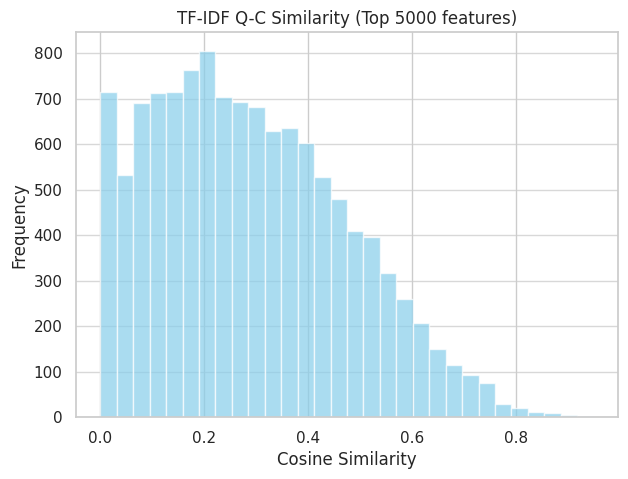

TF-IDF Q-C Similarity (Top 5000 features) - Mean: 0.290, Median: 0.270, Min: 0.000, Max: 0.950


In [ ]:


if not df.empty:
    print("\n--- 1. Lexical Similarity: TF-IDF (using original text, lowercased) ---")
    tfidf_similarities = []
    try:
        # Initialize TfidfVectorizer - basic preprocessing: lowercase, stopword removal
        tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                           lowercase=True,
                                           max_features=MAX_TFIDF_FEATURES)

        # Create a combined corpus of questions and contexts for fitting IDF
        corpus_for_tfidf = pd.concat([
            df["question"].astype(str),
            df["context"].astype(str)
        ])
        tfidf_vectorizer.fit(corpus_for_tfidf)

        # Transform questions and contexts
        q_tfidf_vectors = tfidf_vectorizer.transform(df["question"].astype(str))
        c_tfidf_vectors = tfidf_vectorizer.transform(df["context"].astype(str))

        # Calculate cosine similarities
        for q_vec, c_vec in zip(q_tfidf_vectors, c_tfidf_vectors):
            similarity = cosine_similarity(q_vec, c_vec)[0, 0]
            tfidf_similarities.append(similarity)

        plot_similarity_histogram(tfidf_similarities,
                                  f"TF-IDF Q-C Similarity (Top {MAX_TFIDF_FEATURES} features)")
    except Exception as e:
        print(f"Error during TF-IDF analysis: {e}")
else:
    print("Skipping TF-IDF analysis as no data was sampled.")

## Semantic Similarity with Pre-trained GloVe Embeddings

Here we use GloVe vectors (e.g. “glove-twitter-50” and “glove-wiki-gigaword-50”) to compute semantic similarity between each question and its corresponding context.  
- Text is lowercased and tokenized into words.  
- Each word is mapped to its 50-dimensional GloVe embedding.  
- We average the embeddings over all tokens in the question and context separately.  
- Finally, we compute cosine similarity between these averaged vectors to quantify semantic alignment.



--- 2. Semantic Similarity: Pre-trained GloVe Embeddings ---

Processing with GloVe-Twitter-50...
[==================================================] 100.0% 199.5/199.5MB downloaded
GloVe-Twitter-50 loaded (vector size: 50).


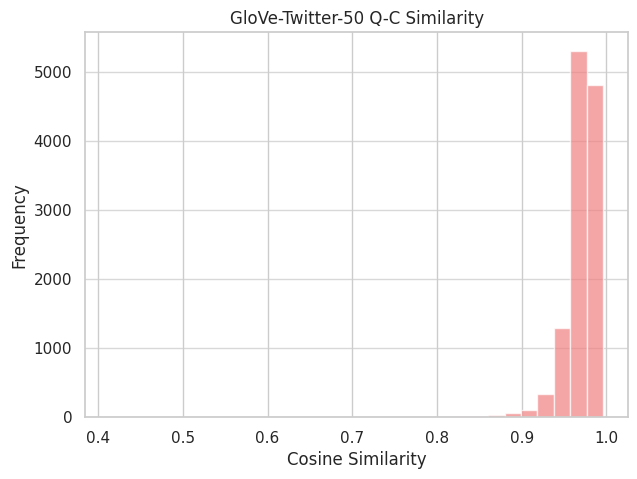

GloVe-Twitter-50 Q-C Similarity - Mean: 0.970, Median: 0.974, Min: 0.414, Max: 0.996

Processing with GloVe-Wiki-Gigaword-50...
[==================================================] 100.0% 66.0/66.0MB downloaded
GloVe-Wiki-Gigaword-50 loaded (vector size: 50).


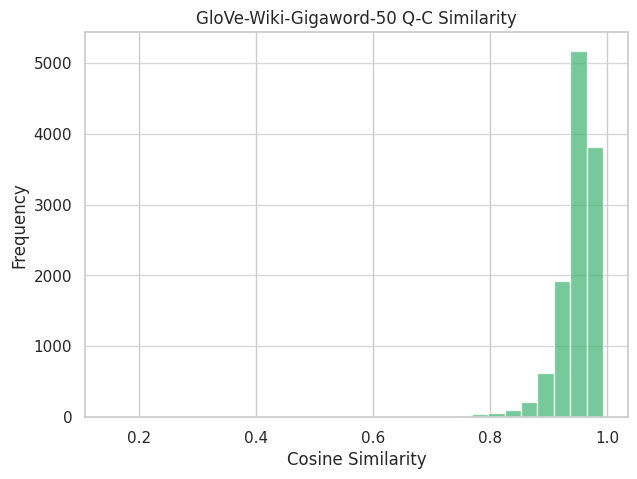

GloVe-Wiki-Gigaword-50 Q-C Similarity - Mean: 0.948, Median: 0.956, Min: 0.151, Max: 0.994


In [ ]:


if not df.empty:
    print("\n--- 2. Semantic Similarity: Pre-trained GloVe Embeddings ---")

    # Helper function to get average GloVe embedding for a text
    def get_average_glove_embedding(text, model):
        # Simple tokenization: lowercase and find words
        tokens = re.findall(r"\b\w+\b", str(text).lower())
        # Get vectors for tokens present in the model's vocabulary
        word_vectors = [model[token] for token in tokens if token in model.key_to_index] # Gensim 4.x+
        if not word_vectors:
            return np.zeros(model.vector_size) # Return zero vector if no words found
        return np.mean(word_vectors, axis=0) # Average of word vectors

    glove_models_to_test = {
        "GloVe-Twitter-50": "glove-twitter-50",
        "GloVe-Wiki-Gigaword-50": "glove-wiki-gigaword-50"
    }
    all_glove_similarities = {}

    for model_name, glove_id in glove_models_to_test.items():
        print(f"\nProcessing with {model_name}...")
        current_glove_model = None
        try:
            current_glove_model = api.load(glove_id)
            print(f"{model_name} loaded (vector size: {current_glove_model.vector_size}).")
        except Exception as e:
            print(f"Could not load {model_name}: {e}")
            continue

        similarities_for_model = []
        for _, row in df.iterrows():
            q_text, c_text = row["question"], row["context"]
            q_emb = get_average_glove_embedding(q_text, current_glove_model)
            c_emb = get_average_glove_embedding(c_text, current_glove_model)
            similarity = cosine_similarity(q_emb.reshape(1, -1), c_emb.reshape(1, -1))[0, 0]
            similarities_for_model.append(similarity)

        all_glove_similarities[model_name] = similarities_for_model
        plot_similarity_histogram(similarities_for_model, f"{model_name} Q-C Similarity", color='lightcoral' if 'Twitter' in model_name else 'mediumseagreen')
else:
    print("Skipping GloVe analysis as no data was sampled.")

## Why GloVe Similarities Are Typically Very High

- **Average pooling flattens differences:** Common words (e.g. “the”, “and”) dominate the mean, pushing question/context vectors close together.  
- **Shared vocabulary bias:** Overlapping tokens in Q and C drive cosine scores toward 1.0.  
- **No sentence‐level nuance:** GloVe ignores word order and context, so different sentences with the same words get nearly identical embeddings.

**Transformer encoders** (e.g. `all-MiniLM-L6-v2`) yield lower, more varied scores by modeling syntax, context, and token importance—making them better for fine‐grained semantic similarity.  


## Semantic Similarity with Sentence Transformers

We leverage pre-trained sentence encoders (e.g. `all-MiniLM-L6-v2`) to embed each question and its context into dense vectors that capture full-sentence and paragraph-level semantics. After encoding:

1. **Encode** the question and context separately.  
2. **Compute cosine similarity** between the two embeddings.  





--- 3. Semantic Similarity: Sentence Transformers (all-MiniLM-L6-v2) ---
Loading Sentence Transformer model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence Transformer model loaded.
Encoding questions...


Batches:   0%|          | 0/375 [00:00<?, ?it/s]

Encoding contexts...


Batches:   0%|          | 0/375 [00:00<?, ?it/s]

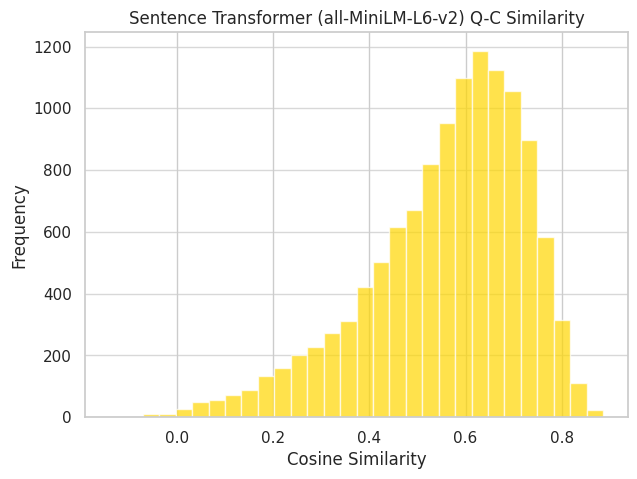

Sentence Transformer (all-MiniLM-L6-v2) Q-C Similarity - Mean: 0.559, Median: 0.591, Min: -0.139, Max: 0.886


In [ ]:


if not df.empty:
    print("\n--- 3. Semantic Similarity: Sentence Transformers (all-MiniLM-L6-v2) ---")
    st_similarities = []
    st_model_name = "all-MiniLM-L6-v2"
    st_model = None

    try:
        print(f"Loading Sentence Transformer model: {st_model_name}...")
        st_model = SentenceTransformer(st_model_name)
        print("Sentence Transformer model loaded.")
    except Exception as e:
        print(f"Error loading Sentence Transformer model: {e}")

    if st_model:
        try:
            # Prepare questions and contexts for batch encoding (more efficient)
            questions = df["question"].astype(str).tolist()
            contexts = df["context"].astype(str).tolist()

            print("Encoding questions...")
            q_embeddings = st_model.encode(questions, show_progress_bar=True)
            print("Encoding contexts...")
            c_embeddings = st_model.encode(contexts, show_progress_bar=True)

            # Calculate cosine similarities
            for i in range(len(q_embeddings)):
                similarity = util.pytorch_cos_sim(q_embeddings[i], c_embeddings[i]).item()
                st_similarities.append(similarity)

            plot_similarity_histogram(st_similarities, f"Sentence Transformer ({st_model_name}) Q-C Similarity", color='gold')
        except Exception as e:
            print(f"Error during Sentence Transformer similarity calculation: {e}")
else:
    print("Skipping Sentence Transformer analysis as no data was sampled.")

## Custom Word2Vec on Contexts

- **Preprocess:** lowercase, remove non-alphanumeric, tokenize  
- **Train:** Word2Vec on all context token lists  
- **Use:** average embeddings + cosine similarity  
-  **Visualize** word vectors with t-SNE  


In [ ]:


if not df.empty: # Use the full df for training Word2Vec for a richer vocabulary
    print("\n--- 4. Custom Word Embeddings: Word2Vec Trained on Contexts ---")

    # Preprocessing function specific for Word2Vec training
    def preprocess_text_for_w2v(text_series):
        processed_sentences = []
        for text_content in text_series.astype(str):
            text_content = text_content.lower()
            text_content_no_punct = re.sub(r'[^\w\s\.\?!]', '', text_content)
            sentences = re.split(r'(?<=[.?!])\s+', text_content_no_punct)

            for sentence in sentences:
                # Tokenize: find words (alphanumeric sequences)
                tokens = re.findall(r"\b\w+\b", sentence)
                if len(tokens) > 1: # Only consider sentences with more than one token
                    processed_sentences.append(tokens)
        return processed_sentences

    print("Preprocessing contexts for Word2Vec training...")
    # Using all available contexts from 'df' for training for a richer vocabulary
    context_corpus_for_w2v = preprocess_text_for_w2v(df["context"])

    w2v_model = None
    if context_corpus_for_w2v:
        try:
            print(f"Training Word2Vec model on {len(context_corpus_for_w2v)} sentences from contexts...")
            w2v_model = Word2Vec(sentences=context_corpus_for_w2v,
                                 vector_size=W2V_VECTOR_SIZE,
                                 window=5,
                                 min_count=5, # Ignore words with total frequency lower than this
                                 workers=4)   # Number of worker threads to train the model
            print(f"Custom Word2Vec model vocabulary size: {len(w2v_model.wv.index_to_key)}")

            # --- Visualization of Word Embeddings (t-SNE) ---
            if len(w2v_model.wv.index_to_key) > 0:
                num_words_for_tsne = min(300, len(w2v_model.wv.index_to_key)) # Sample for visualization
                words_for_tsne = w2v_model.wv.index_to_key[:num_words_for_tsne]
                word_vectors_for_tsne = w2v_model.wv[words_for_tsne]

                print(f"\nRunning t-SNE for {num_words_for_tsne} word embeddings (this might take a moment)...")
                perplexity_val = min(30, num_words_for_tsne - 1 if num_words_for_tsne > 1 else 1)
                perplexity_val = max(1, perplexity_val)

                tsne = TSNE(n_components=3,
                            random_state=RANDOM_STATE,
                            n_iter=1000, # Default is 1000, can increase for better stability
                            perplexity=perplexity_val)
                tsne_embeddings = tsne.fit_transform(word_vectors_for_tsne)

                tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y', 'z'])
                tsne_df['word'] = words_for_tsne

                fig_w2v = px.scatter_3d(tsne_df, x='x', y='y', z='z', text='word',
                                        title=f"3D t-SNE of Custom Word Embeddings (Top {num_words_for_tsne} words from Contexts)")
                fig_w2v.update_traces(marker=dict(size=2), textfont_size=8)
                fig_w2v.show()


        except Exception as e:
            print(f"Error during custom Word2Vec analysis: {e}")
    else:
        print("No sentences available after preprocessing contexts for Word2Vec training.")
else:
    print("Skipping custom Word2Vec analysis as DataFrame is empty.")


--- 4. Custom Word Embeddings: Word2Vec Trained on Contexts ---
Preprocessing contexts for Word2Vec training...
Training Word2Vec model on 374134 sentences from contexts...
Custom Word2Vec model vocabulary size: 45006

Running t-SNE for 300 word embeddings (this might take a moment)...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


With our embeddings we can perform some interesting and easy tasks. For example we can sum 2 embeddings and see what is the reculting word

In [ ]:
vec = w2v_model.wv['duke'] + (w2v_model.wv['woman'] - w2v_model.wv['man'])
vec, w2v_model.wv.most_similar([vec], topn=10)

(array([ 1.6151296e+00, -2.3413488e-01,  9.7060817e-01, -1.2051917e+00,
        -2.8115433e-01,  8.4582585e-01, -8.5059285e-02,  2.3599388e-01,
        -1.3042125e+00,  3.5266480e-01,  2.9128146e-01, -2.0841032e-02,
         9.6544880e-01,  1.4435419e-01, -1.0329579e+00, -7.7035534e-01,
         1.5382591e+00,  4.6272331e-01, -8.1079531e-01,  4.0623896e-02,
        -2.5150782e-01,  9.5354950e-01,  7.6551509e-01, -1.3464825e+00,
        -1.7080320e-01,  4.3690127e-01,  1.7830729e-04,  1.0688031e+00,
         3.3437696e-01, -3.1901136e-02,  5.2503300e-01,  6.4193970e-01,
         9.6174568e-01, -8.5135108e-01, -1.0840032e+00, -1.0301068e+00,
         5.3630704e-01,  3.3708370e-01,  1.9157839e+00,  7.9224110e-02,
        -3.3694154e-01, -3.5164219e-01,  5.7653165e-01,  8.0873406e-01,
         1.1676770e+00, -2.4374413e-01, -7.3451179e-01, -1.0092515e-01,
         5.3152263e-02,  1.2172102e+00], dtype=float32),
 [('bachelor', 0.6693355441093445),
  ('infant', 0.666530966758728),
  ('postdo

Or we choose a random word, see what are the most similar words based on the embeddings we just computed, and have a 3d visualization of those words. I actually thought they would be closer in space, but they are at least semantically related


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px

# we choose a random word and find the most similar
example_word_w2v = 'cake'
if example_word_w2v in w2v_model.wv:
    neighbors = w2v_model.wv.most_similar(example_word_w2v, topn=5)
    words_for_viz = [example_word_w2v] + [w for w, _ in neighbors]
else:
    words_for_viz = w2v_model.wv.index_to_key[:6]


word_vectors = w2v_model.wv[words_for_viz]

perplexity_val = min(30, len(words_for_viz) - 1)
perplexity_val = max(1, perplexity_val)
tsne = TSNE(n_components=3,
            random_state=RANDOM_STATE,
            n_iter=1000,
            perplexity=perplexity_val)
tsne_embeddings = tsne.fit_transform(word_vectors)

tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y', 'z'])
tsne_df['word'] = words_for_viz

fig = px.scatter_3d(
    tsne_df,
    x='x', y='y', z='z',
    text='word',
    title=f"3D t-SNE: '{example_word_w2v}' & Top {len(words_for_viz)-1} similar"
)
fig.update_traces(marker=dict(size=4), textfont_size=10)
fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Finally i will just save the model so that if we need it in other notebooks we can easily load it

In [ ]:
# saving
w2v_model.save("w2v_custom.model")

# later we can load it like this
'''from gensim.models import Word2Vec
w2v_model = Word2Vec.load("w2v_custom.model")'''


## Similarity and Embedding Analysis Complete

Analysis performed on  question-context pairs from our dataset.

**Methods explored:**
1. **Lexical Similarity:** TF-IDF (original text, lowercased, stopword removal)  
2. **Semantic Similarity:** Pre-trained GloVe Embeddings (Twitter & Wikipedia, original text, lowercased)  
3. **Semantic Similarity:** Sentence Transformers (`all-MiniLM-L6-v2`, original text)  
4. **Custom Word Embeddings:** Word2Vec trained on preprocessed context data, with t-SNE visualization


